# py4DSTEM Tutorial - Strain Mapping of a Quantum Well
---

### Introduction

This is a tutorial notebook intended to teach you how to use py4DSTEM to measure the local strain from a 4D-STEM dataset. We will perform the following steps:

* [Part 0 - Import py4DSTEM, download and load the dataset.](#part_00)
* [Part 1 - Quick visualization of the dataset, fix jitter.](#part_01)
* [Part 2 - Create a probe template.](#part_02)
* [Part 3 - Hyperparameter tuning for Bragg disk detection.](#part_03)
* [Part 4 - Find all Bragg disk positions in each diffraction image.](#part_04)
* [Part 5 - Define lattice, fit lattice to all measured Bragg peaks.](#part_05)
* [Part 6 - Generate strain maps.](#part_06)
* [Part 7 - Save the results, and export strain maps.](#part_07)


### Acknowledgements

* This tutorial was written by Colin Ophus and the py4DSTEM team at Berkeley Lab (clophus@lbl.gov).

* The 4D-STEM dataset used here is from Ian MacLaren, adapted from [reference]


### Version
Last updated on 2021-06-01 with py4DSTEM version 0.12.0.

---
<a class="anchor" id="part_00"></a>
# Part 0 - Import py4DSTEM, download and load the data.

In [1]:
# Initialization - import the needed packages.
# For this tutorial, we will need py4DSTEM, numpy, and h5py
import py4DSTEM
import numpy as np
import h5py    

You can download the tutorial dataset here: (151 megabytes)
* [Quantum well 4D-STEM experiment](https://drive.google.com/file/d/1GTxIaxET98vdRMbF8IhhaahipC8NX7iP/view?usp=sharing)

If you are running in **binder** run the cell below, otherwise skip.

In [ ]:
from py4DSTEM.io import download_file_from_google_drive
download_file_from_google_drive("1GTxIaxET98vdRMbF8IhhaahipC8NX7iP", "/home/jovyan/data/IanQW2.hspy")

In [4]:
# Set the file paths for the input dataset.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change this path.
file_path_input = '/home/jovyan/data/IanQW2.hspy'
# file_path_input = '/Users/Ben/Work/Data/py4DSTEM_tutorials/IanQW2.hspy'
# file_path_input = 'C:/Data/IanQW2.hspy'

# Set the file path for saving the results - it's usually easier to define all file paths at the start
file_path_output_h5 = '/home/jovyan/data/IanQW2_analysis_v01.h5'
file_path_output_pdf = '/home/jovyan/data/IanQW2_strain_maps.pdf'
# file_path_output_h5 = '/Users/Ben/Work/Data/py4DSTEM_tutorials/IanQW2_analysis_v01.h5'
# file_path_output_pdf = '/Users/Ben/Work/Data/py4DSTEM_tutorials/IanQW2_strain_maps.pdf'
# file_path_output_h5 = 'C:/Data/IanQW2_analysis_v01.h5'
# file_path_output_pdf = 'C:/Data/IanQW2_strain_maps.pdf'

In [5]:
# This dataset is stored in the Hyperspy HDF5 file.
# We will add a reader for this format to py4DSTEM soon.
# For now, we will manually load the data.

# So, our first step is to list all of the groups inside the .h5 file: 
# (code adapted from issue #406 on the h5py github repo)
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print('%s %s' % (key, val))

f = h5py.File(file_path_input,'r')
f.visititems(print_attrs)

Experiments
Experiments/-fpd_expt-fpd_data
package hyperspy
package_version 1.5.2
Experiments/-fpd_expt-fpd_data/axis-0
name scanY
navigate True
offset 98.89943613154328
scale 0.49075146839697936
size 16
units nm
Experiments/-fpd_expt-fpd_data/axis-1
name scanX
navigate True
offset -39.0916848304989
scale 0.49075146839697936
size 155
units nm
Experiments/-fpd_expt-fpd_data/axis-2
name detY
navigate False
offset -0.0321688017472044
scale 0.00025131876365003247
size 256
units mrad
Experiments/-fpd_expt-fpd_data/axis-3
name detX
navigate False
offset -0.0321688017472044
scale 0.00025131876365003247
size 256
units mrad
Experiments/-fpd_expt-fpd_data/data
Experiments/-fpd_expt-fpd_data/learning_results
Experiments/-fpd_expt-fpd_data/metadata
Experiments/-fpd_expt-fpd_data/metadata/General
title /fpd_expt/fpd_data
Experiments/-fpd_expt-fpd_data/metadata/General/comments
Experiments/-fpd_expt-fpd_data/metadata/General/microscope
name ARM200cF
voltage 200000.0
Experiments/-fpd_expt-fpd_data/me

In [6]:
# In the HDF5 file, the data we want is stored here:
# /Experiments/-fpd_expt-fpd_data/data

# We want to import this experiment as a py4DSTEM datacube.
# note that we are accessing a "dataset" inside various groups (groups are the HDF5 equivalent of directories)
dataset = py4DSTEM.io.DataCube(data=f['Experiments/-fpd_expt-fpd_data/data'][...])

In [7]:
# We can verify the dataset is 4 dimensional by checking the shape:
dataset.data.shape

(16, 155, 256, 256)

This dataset is indeed 4D, and contains [16 x 155] probe positions, with a [256x256] sized image for each probe position.

---
<a class="anchor" id="part_01"></a>
# Part 1 - Quick visualization of dataset, fix jitter.

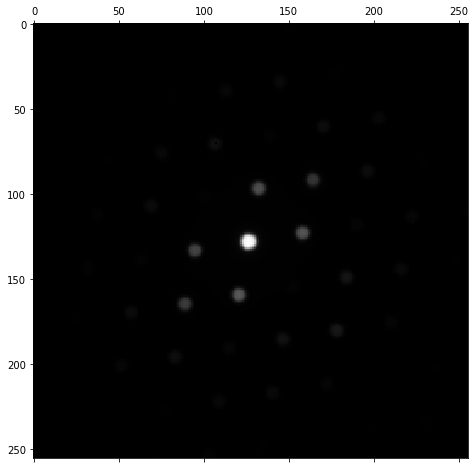

In [8]:
# Examine the mean diffraction space image by averaging over all probe positions:
diffraction_pattern_mean = np.mean(dataset.data, axis=(0,1))
py4DSTEM.visualize.show(diffraction_pattern_mean)

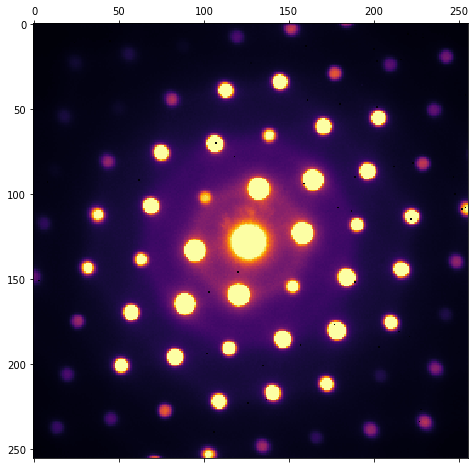

In [9]:
# Typical 4D-STEM scans are dominated by the contrast of the (unstalled) center disk.
# Lets scale the intensity by manually specifying the output color range as:
# minimum value = 0
# maximum value = 400
# We will also use the 'inferno' colormap.
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    clipvals='manual',
    min=0,
    max=400,
    cmap='inferno')

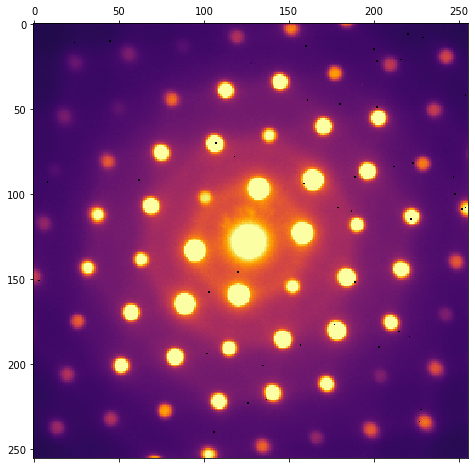

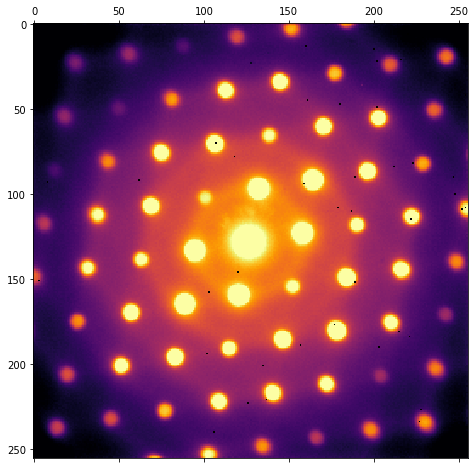

In [10]:
# As we can see, linear scaling makes it difficult to visualize all peaks simultaneously.
# This is because Bragg peak intensities can easily vary by orders of magnitude.
# Thus it often makes sense to visualize diffraction space images with power law or logarithmic scaling:

py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='power',
    power = 0.5,
    clipvals='manual',
    min=0,
    max=400,
    cmap='inferno')
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    scaling='log',
    clipvals='manual',
    min=10,  
    max=400,
    cmap='inferno')
# Note for log scaling, we change min from 0 to 10, since log(0) = -infinity.

This dataset is ideal for 4D-STEM strain mapping, as it appears to contain only a single crystalline orientation and many diffraction spots.

Let's next take a look at virtual bright field (BF) and dark field (DF) images.

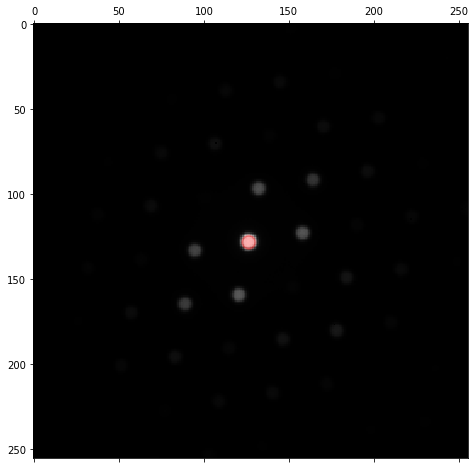

Estimated probe radius = 3.89 pixels


In [11]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(diffraction_pattern_mean)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    diffraction_pattern_mean, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

In [12]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0)
# We will expand the BF radius slightly (+ 2 px).
# The DF virtual detector can be set to all remaining pixels.
expand_BF = 2.0
image_BF = py4DSTEM.process.virtualimage.get_virtualimage_circ(
    dataset, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF = py4DSTEM.process.virtualimage.get_virtualimage_ann(
    dataset, 
    qx0, qy0, 
    probe_semiangle + expand_BF,
    1e3)

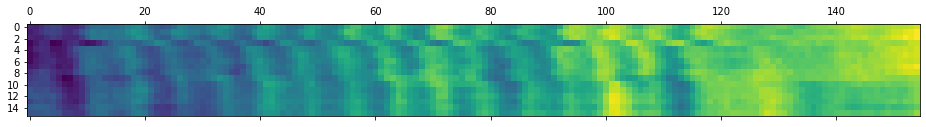

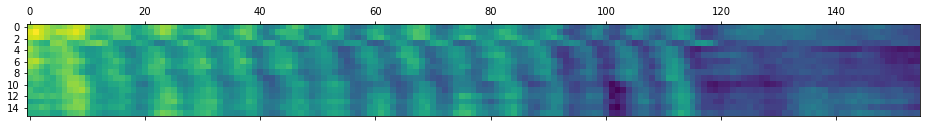

In [13]:
# Show the BF and DF images
py4DSTEM.visualize.show(
    image_BF,
    figsize=(16,2),
    cmap='viridis')
py4DSTEM.visualize.show(
    image_DF,
    figsize=(16,2),
    cmap='viridis')

As expected, the BF and DF images show opposite contrast scaling.

We also can see that many horizontal shifts in the scanlines are visible - possibly due to instrument or detector readout errors. We will manually correct them for this tutorial by shifting the scanlines 'by eye.'

In [14]:
# Copy the dataset, shift rows manually.
# Here we copy the data instead of overwriting dataset, 
# to ensure the rows are shifted only once regardless of how many times the cell is run
dataset_corr = py4DSTEM.io.DataCube(data=np.copy(dataset.data))
dataset_corr.data[4:9,:,:,:] = np.roll(dataset_corr.data[4:9,:,:,:],2,axis=1)
dataset_corr.data[9,:,:,:] = np.roll(dataset_corr.data[9,:,:,:],1,axis=0)
dataset_corr.data[3,:,:,:] = np.roll(dataset_corr.data[3,:,:,:],-4,axis=0)
# The next three lines aren't strictly necessary when running locally, but it is for running in binder.
# However, it good practice to be mindful of memory resources particularly with larger datasets
del dataset # delete 'dataset' variable as it is no longer used
import gc # this is one of python's memory management systems, and is short for garbage collection
gc.collect() # we are explicitly telling python to clear up memory, rather than leaving it to python to manage 

8553

In [15]:
# # Copy the dataset, shift rows
# dataset_corr = py4DSTEM.io.DataCube(data=np.copy(dataset.data))
# dataset_corr.data[4:9,:,:,:] = np.roll(dataset_corr.data[4:9,:,:,:],2,axis=1)
# dataset_corr.data[9,:,:,:] = np.roll(dataset_corr.data[9,:,:,:],1,axis=0)
# dataset_corr.data[3,:,:,:] = np.roll(dataset_corr.data[3,:,:,:],-4,axis=0)

In [16]:
# re-calculate the virtual BF and DF images
image_BF_corr = py4DSTEM.process.virtualimage.get_virtualimage_circ(
    dataset_corr, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF_corr = py4DSTEM.process.virtualimage.get_virtualimage_ann(
    dataset_corr, 
    qx0, qy0, 
    probe_semiangle + expand_BF,
    1e3)

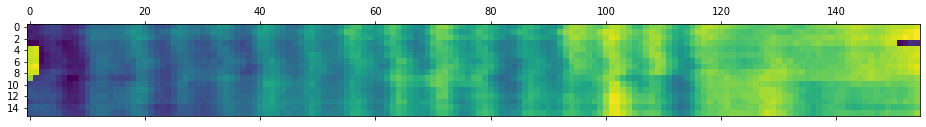

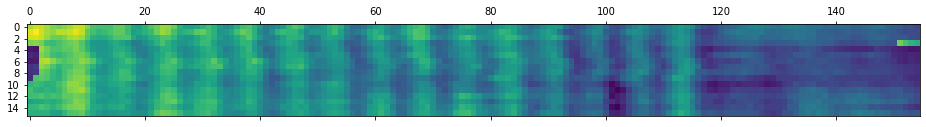

In [17]:
# Show the BF and DF images from the corrected dataset
py4DSTEM.visualize.show(
    image_BF_corr,
    figsize=(16,2),
    cmap='viridis')
py4DSTEM.visualize.show(
    image_DF_corr,
    figsize=(16,2),
    cmap='viridis')

Much better!  It's not perfect, but we can now proceed.

---
<a class="anchor" id="part_02"></a>
# Part 2 - Create probe template.

py4DSTEM uses a method called 'template matching' to find the position of Bragg disks. Ideally, we would use a vacuum measurement of the STEM probe for this template. Since we do not have a vacuum measurement for this dataset, we will instead produce it by cropping around the center beam.

100%|███████████████████████████████████████████████████████████████████████████| 2479/2479 [00:00<00:00, 12490.58it/s]


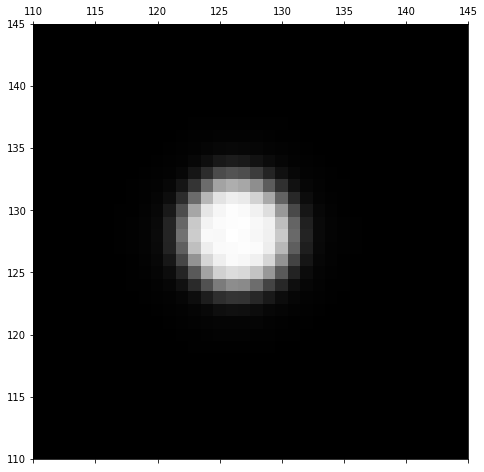

In [18]:
# We will use a py4DSTEM function to find and crop around the center beam.
# Because it is the brightest spot, we will threshold at 50% of this value (mask_threshold=0.5),
# and then produce a mask of 8 pixels around the initial probe mask (mask_expansion=8).

# Get the mean probe
probe_cropped = py4DSTEM.process.diskdetection.get_probe_from_4Dscan_ROI(
    dataset_corr,
    np.ones(image_BF.shape, dtype=bool), 
    mask_threshold=0.5,
    mask_expansion=8,
    align=False)

# plot the output probe - zoomed in around it
fig, ax = py4DSTEM.visualize.show(
    probe_cropped,
    returnfig=True)
ax.set_xlim(110, 145);
ax.set_ylim(110, 145);

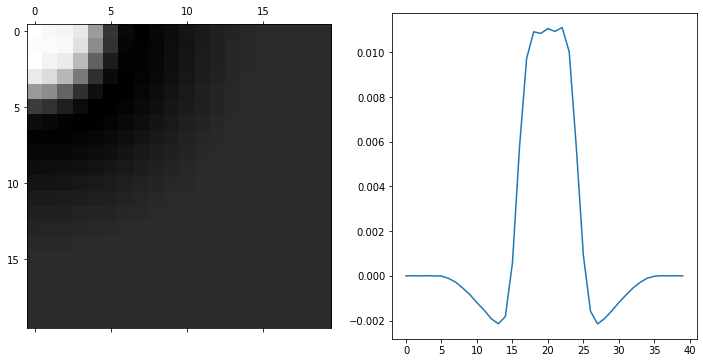

In [19]:
# Next, we need to shift this probe to the origin and apply normalization by subtracting a sigmoid function.
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
    probe_cropped, 
    probe_semiangle * 0.0,                                                        
    probe_semiangle * 4.0,)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=20, 
    L=20, 
    W=1)

---
<a class="anchor" id="part_03"></a>
# Part 3 - Hyperparameter tuning for Bragg disk detection.

The 'template matching' procedure we will use is image correlation. Essentially, we convolve the probe template with each diffraction pattern. The position of local maxima tell us where the Bragg disks are located. 

However, py4DSTEM has various parameters we can tune to improve the disk detection.  Our goal is to find as many true Bragg disks as possible, while avoiding false positives.  Try changing the various parameters below to test this for yourself!

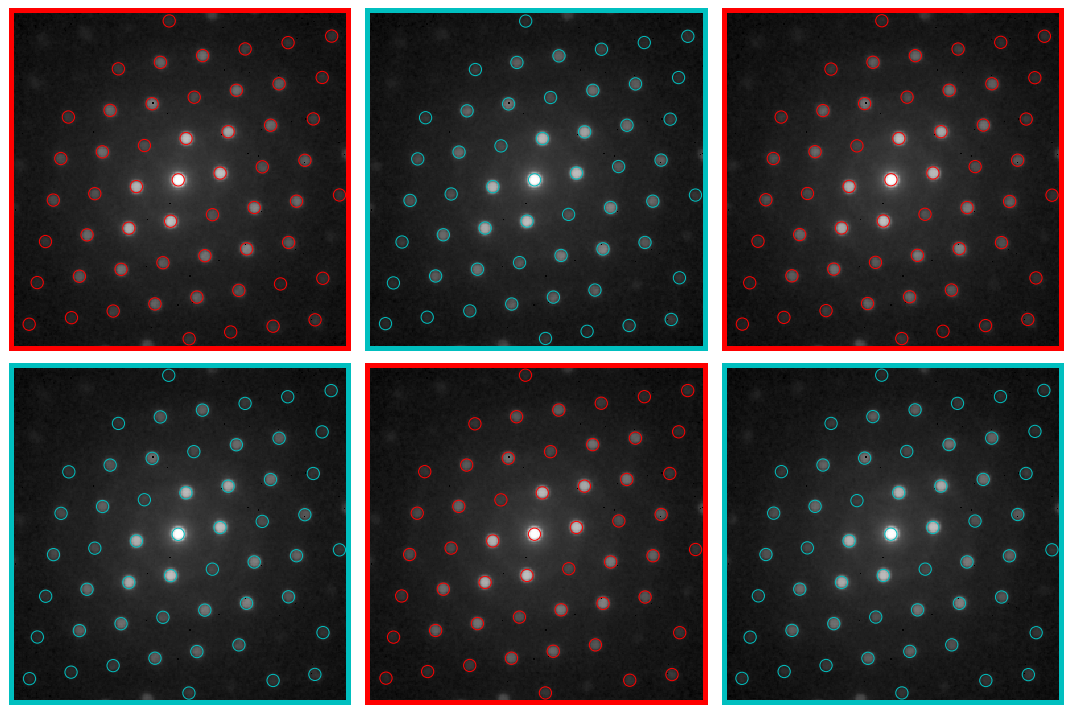

In [20]:
# specify some probe positions
rxs = 8,8,8,8,8,8
rys = 25,50,75,100,125,150
colors=['r','c','r','c','r','c']

dp0 = dataset_corr.data[rxs[0],rys[0],:,:]
dp1 = dataset_corr.data[rxs[1],rys[1],:,:]
dp2 = dataset_corr.data[rxs[2],rys[2],:,:]
dp3 = dataset_corr.data[rxs[3],rys[3],:,:]
dp4 = dataset_corr.data[rxs[4],rys[4],:,:]
dp5 = dataset_corr.data[rxs[5],rys[5],:,:]

# Run the disk detection on the selected DPs
corrPower=1
sigma=0
edgeBoundary=4
minRelativeIntensity=0.001
relativeToPeak=0
minPeakSpacing=0
maxNumPeaks=100
subpixel='poly'
upsample_factor=20

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset_corr,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

py4DSTEM.visualize.show_image_grid(
    lambda i:[dp0,dp1,dp2,dp3,dp4,dp5][i],H=2,W=3,
    axsize=(5,5),
    scaling='power',
    power=0.25,                  
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=150)

In [21]:
# Here are some good settings for this dataset - written out again in case you need a reference
# corrPower=1
# sigma=0
# edgeBoundary=8
# minRelativeIntensity=0.001
# relativeToPeak=0
# minPeakSpacing=1
# maxNumPeaks=100
# subpixel='multicorr'
# upsample_factor=20

---
<a class="anchor" id="part_04"></a>
# Part 4 - Find all Bragg disk positions in each diffraction pattern.

We now have all of the ingredients necessary for precise measurements of the Bragg disk positions - a probe template for use in the correlation image, and hyperparameters tuned on various test images throughout the dataset.  The next step is to run the disk detection routine on all diffraction patterns.

This process will take about 30 seconds on an average laptop, or on **binder**.

In [22]:
bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset_corr,
    probe=probe_kernel,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor
)

Finding Bragg Disks: 100%|████████████████████████████████████████████████████████| 2.48k/2.48k [00:26<00:00, 92.7DP/s]


To generate the highest quality strain maps, we need to **calibrate** our data.  Specifically we would need to measure the shifts of patterns in diffraction space as a function of the STEM probe position, measure the ellipticity of the patterns (distortions introduced by the condenser or projector lenses of the TEM), and finally estimate the absolute pixel size.

Here however, we will assume no pattern shift and neglect any ellipticity. Because many strain maps are **relative** measurements of distortions, you can get away with not running these calibrations in many cases.  However you should never forget that they are present! 

In [23]:
# Center the Bragg disk positions about the origin
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

100%|█████████████████████████████████████████████████████████████████████████████| 2480/2480 [00:07<00:00, 332.41it/s]


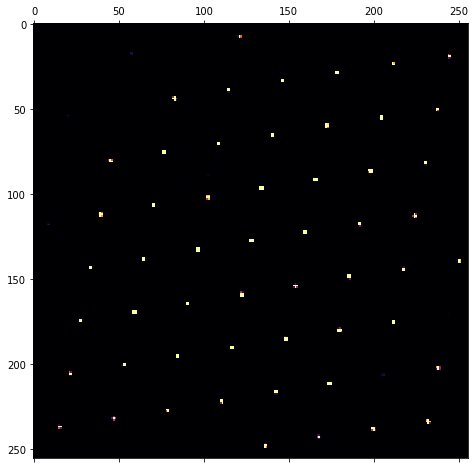

In [24]:
# Next, we will compute and plot 'Bragg vector map'. 
# This is a 2D histogram of all detected Bragg peaks.

# Compute the Bragg vector map
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    dataset_corr.Q_Nx,
    dataset_corr.Q_Ny)

# plot the Bragg vector map
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='inferno',
    clipvals='manual',
    min=0,
    max=1e4)

The vast majority of detected peaks fall on the lattice.  We can see a few false positives, and more if we scale the colour range of the plotted image.

However, py4DSTEM has multiple ways of filtering out these false positives, so they are unlikely to affect the final result. The primary way we compute an accurate lattice is to weight the signals by the corrleation intensities of all peaks in the least squares fit of the lattice. 

It is however useful to examine the distribution of false positives. These could certainly be removed by additional hyperparameter tuning (for example by enforcing a minimum peak spacing).

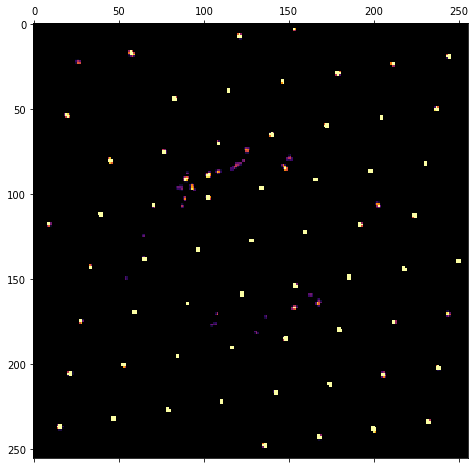

In [25]:
# plot the Bragg vector map with the intensity scaled way to up reveal any false positives.
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='inferno',
    clipvals='manual',
    min=0,
    max=1e2,
    scaling='power',
    power=0.5)

---
<a class="anchor" id="part_05"></a>
# Part 5 - Define lattice, fit lattice to all measured Bragg peaks.

The next step is to fit a lattice to the Bragg peaks we measured, in all diffraction images.

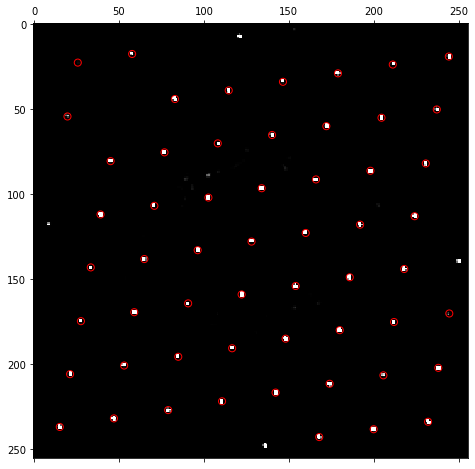

In [26]:
# Grab the local maximum from the Bragg vector map
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=0, 
    edgeBoundary=10,
    minSpacing=20,
    minRelativeIntensity=0.0,
    relativeToPeak=0,
    maxNumPeaks=100,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=1e3,
    open_circles=True)

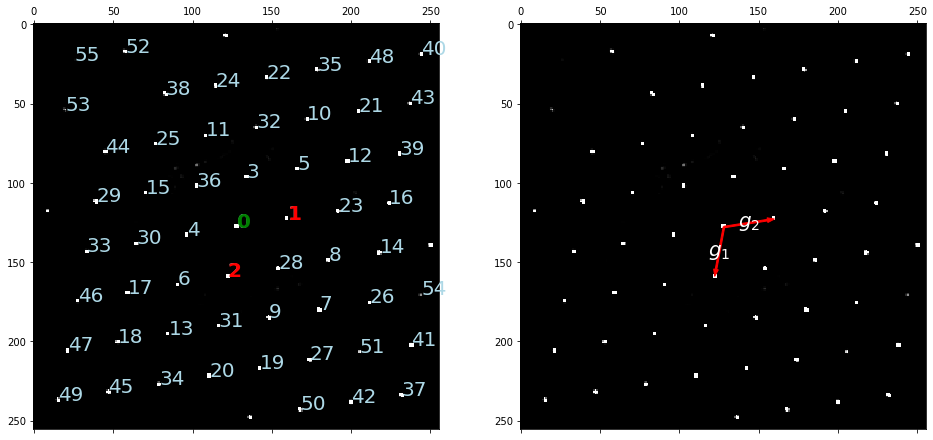

In [27]:
# Define the lattice, which is composed of:
#     -center beam index 
#     -beam index which defines g1
#     -beam index which defines g2
index_0, index_g1, index_g2 = 0, 2, 1

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(16,8),
    clipvals='manual',
    min=0,
    max=1e3,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

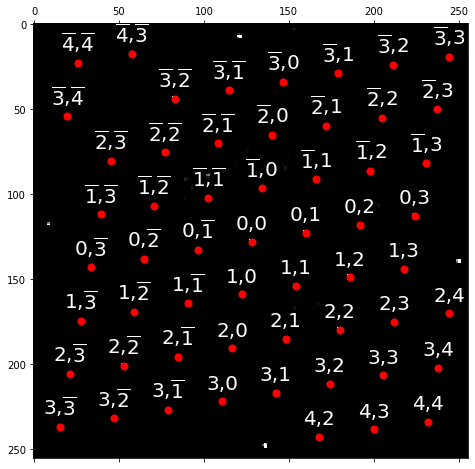

In [28]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0,qy0,
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=1e3,
    braggdirections=braggdirections,
    points=True)

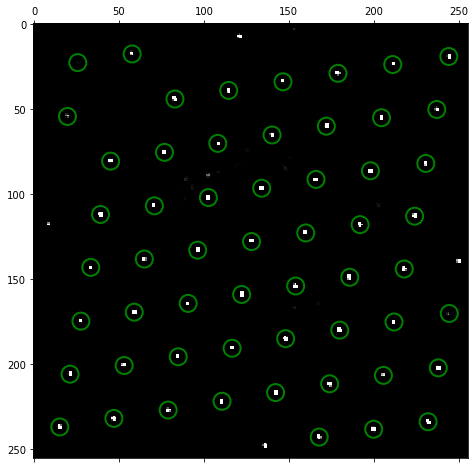

In [29]:
# Define a maximum peak spacing - this is the position tolerance for including a detected peak in the lattice fit.
# Note - be careful with this tolerance - if it is too small, false positive peaks can be turned into lattice fits!
max_peak_spacing = 5

# Plot it
py4DSTEM.visualize.show_max_peak_spacing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=1e3,
    spacing=max_peak_spacing,
    braggdirections=braggdirections)

In [30]:
# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0,
    qy_shift=qy0)

In [31]:
# Finally, we fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|████████████████████████████████████████████████████████████████████████████| 2480/2480 [00:00<00:00, 7944.54it/s]


---
# Part 6 - Generate strain maps.<a class="anchor" id="part_06"></a>

We have now estimated the a crystal lattice in each diffraction pattern. Any change in this lattice should be due to local deformation of the crystal structure (placing the sample in tension along a given direction will lead to compression of the Bragg peaks, and vice versa).  

But what is the zero strain state of the sample? If we were to perform an independent calibration of this dataset, we could measure strain with respect to bulk values (typically measured with x-ray diffraction). However, since that is not possible here, we will define the reference strain state as the substrate, to the right of the quantum well structures.

We will start by calculating the strain with respect to the median lattice parameters.

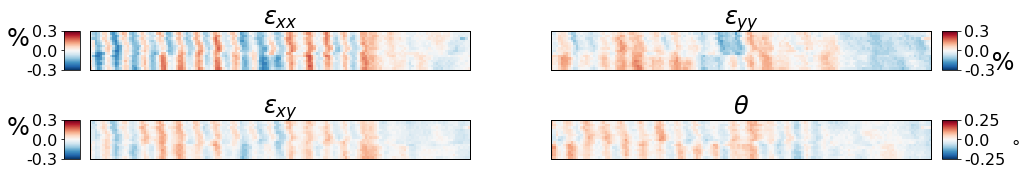

In [32]:
# Compute the strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset_corr.R_Nx,dataset_corr.R_Ny),dtype=bool))

# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap_mediang1g2,
    vrange_exx=[-0.3,0.3],
    vrange_theta=[-0.25,0.25],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(16,3))

The above strain maps show a very common issue - the STEM scan direction is rotated with respect to the detector coordinate axes.

There are a variety of ways to calibrate this scan coil rotation (we typically use independent measurements or the DPC rotation measurement routines), but for the purpose of this tutorial, we will just use pryor knowledge of the sample.

We know the multilayer strain should be nearly flat in the x direction (vertical), parallel to the multilayer interfaces, but will vary strongly in the y direction (horizontal), perpendicular to the multilayer interfaces.  Thus we will use the crystallographic vectors defined above to compute a tensor rotation for the strain fields. 

Looking at the crystal symmetry, the only two reasonable choices are:
* g_reference = g2 + g1

or
* g_reference = g2 - g1

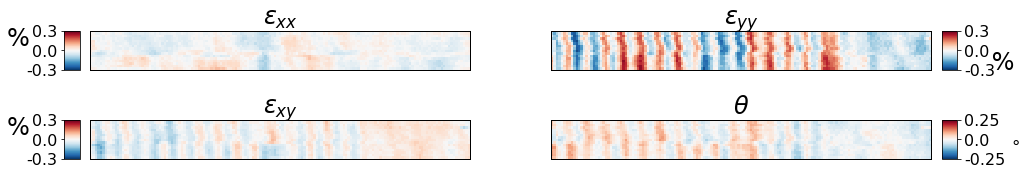

In [33]:
# Compute the strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset_corr.R_Nx,dataset_corr.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = np.subtract(g2, g1)
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-0.3,0.3],
    vrange_theta=[-0.25,0.25],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(16,3))

We have generated reasonable strain maps - the y direction shows the alternating stripes due to the different materials, while the x direction is nearly flat. There is some small leakage of the e_yy strain fields into the e_xy and theta maps, likely due to multiple scattering and / or small tilts of the sample.

However, we want to use the substrate as the reference strain region. For very small strains, we could subtract the mean or median measured strain values from these pixels. It's more correct however to re-define the reference lattice and recompute the strain maps.

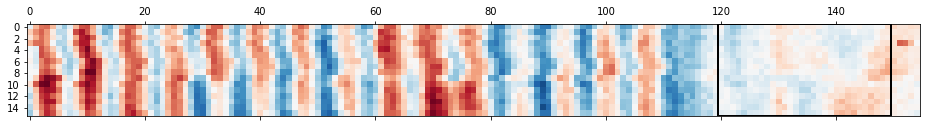

In [34]:
# Define a reference with an ROI, plot it overlaid onto the e_xx strain field.
x0,xf = 0,16
y0,yf = 120,150

py4DSTEM.visualize.show(
    strainmap_mediang1g2.slices['e_xx'],              
    mask=strainmap_mediang1g2.slices['mask'],
    figsize=(16,3),
    cmap='RdBu',
    clipvals='centered',
    min=0,
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'})

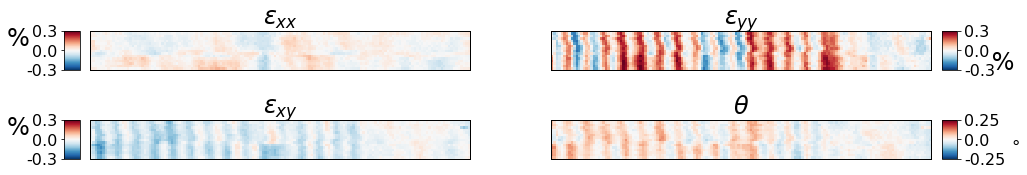

In [35]:
# Get new reference lattice vectors
mask = np.zeros((dataset_corr.R_Nx,dataset_corr.R_Ny),dtype=bool)
mask[x0:xf,y0:yf] = True
g1_ref,g2_ref = py4DSTEM.process.latticevectors.get_reference_g1g2(g1g2_map, mask)

# Recalculate the strain maps using the new reference lattice
strainmap_ROI_g1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_ROI_g1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx=[-0.3,0.3],
    vrange_theta=[-0.25,0.25],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(16,3),
    returnfig=True)

---
# Part 7 - Save the results, and export strain maps.<a class="anchor" id="part_07"></a>

The final part1 of the analysis are:
* Export the strain maps to a vector format such as pdf.
* Save all of the results in case we wish to do further analysis.

In [36]:
# Saving the figure is easy, since in the previous cell we set returnfig=True,
# and saved the figure/axis handles with the line fig,axs = ...

# Using the figure handle, we can simply use the .savefig method:
fig.savefig(file_path_output_pdf)

In [37]:
# Next, we want to save the outputs from the above analyses. 

# The diffraction space arrays we will save are:
diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    probe_cropped,
                    probe_kernel]),    
    slicelabels=['image_mean',
                 'probe_cropped',
                 'probe_kernel'],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF_corr, 
                    image_DF_corr]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output_h5,[diff,
                                      real,
                                      probe_data,
                                      strainmap_ROI,
                                      bragg_peaks_centered],
                 overwrite=True)

  7%|█████▍                                                                       | 175/2480 [00:00<00:01, 1737.31it/s]

Saving DiffractionSlice 'diffraction_images'...
Saving RealSlice 'real_space_images'...
Saving PointList 'probe_data'...
Saving RealSlice 'strain_map_rotated'...
Saving PointListArray 'braggpeaks_centered'...


100%|████████████████████████████████████████████████████████████████████████████| 2480/2480 [00:01<00:00, 1671.95it/s]


In [38]:
# Lastly, we should check the contents of the file we wrote:
py4DSTEM.io.read(file_path_output_h5)

Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DiffractionSlice  (256, 256, 3)           diffraction_images                                    
  1       RealSlice         (16, 155, 2)            real_space_images                                     
  2       RealSlice         (16, 155, 5)            strain_map_rotated                                    
  3       PointList         (3, 1)                  probe_data                                            
  4       PointListArray    (16, 155, 3, -1)        braggpeaks_centered                                   
